<a href="https://colab.research.google.com/github/spirosChv/smartNetsWorkshop/blob/main/neuron/practical3_part5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Simulating dendrites - Part 5

First, we install neuron with python. For more info see [here](https://www.neuron.yale.edu/neuron/download).

In [ ]:
!pip install neuron --quiet

     |████████████████████████████████| 15.0 MB 5.5 MB/s 


We import some basic python packages and the NEURON package.

## Compile ion channel models (.mod files)

In [ ]:
# @title Create the mod file `SlowCa.mod`
# @markdown Execute this cell.
with open("SlowCa.mod", "w") as file:
  file.write("""
    TITLE HVA Ca2+ current

    COMMENT
    Uses fixed eca instead of GHK eqn
    Based on Reuveni, Friedman, Amitai and Gutnick (1993) J. Neurosci. 13: 4609-4621.
    Changed from (AS Oct0899) ca.mod
    
    Author: Zach Mainen, Salk Institute, 1994, zach@salk.edu
    ENDCOMMENT

    INDEPENDENT {t FROM 0 TO 1 WITH 1 (ms)}

    NEURON {
        SUFFIX sca
        USEION ca READ eca WRITE ica
        RANGE m, h, gca, gbar
        RANGE minf, hinf, mtau, htau, inactF, actF
        GLOBAL q10, temp, tadj, vmin, vmax, vshift
    }

    UNITS {
        (mA) = (milliamp)
        (mV) = (millivolt)
        (pS) = (picosiemens)
        (um) = (micron)
        FARADAY = (faraday) (coulomb)
        R = (k-mole) (joule/degC)
        PI = (pi) (1)
    }

    PARAMETER {
        inactF = 3
        actF = 1
        gbar = 0.1 (pS/um2) : 0.12 mho/cm2
        vshift = 0 (mV) : voltage shift (affects all)

        cao = 2.5 (mM) : external ca concentration
        cai (mM)

        temp = 23 (degC) : original temp 
        q10 = 2.3 : temperature sensitivity

        v (mV)
        dt (ms)
        celsius (degC)
        vmin = -120	(mV)
        vmax = 100 (mV)
    }

    ASSIGNED {
        ica (mA/cm2)
        gca (pS/um2)
        eca (mV)
        minf
        hinf
        mtau (ms)
        htau (ms)
        tadj
    }

    STATE { m h }

    INITIAL { 
        trates(v+vshift)
        m = minf
        h = hinf
    }

    BREAKPOINT {
        SOLVE states
        gca = tadj*gbar*m*m*h
        ica = (1e-4) * gca * (v - eca)
    } 

    LOCAL mexp, hexp

    PROCEDURE states() {
        trates(v+vshift)
        m = m + mexp*(minf-m)
        h = h + hexp*(hinf-h)
        VERBATIM
        return 0;
        ENDVERBATIM
    }

    PROCEDURE trates(v) {
        LOCAL tinc
        TABLE minf, mexp, hinf, hexp
        DEPEND dt, celsius, temp, inactF

        FROM vmin TO vmax WITH 199

        rates(v): not consistently executed from here if usetable == 1

        tadj = q10^((celsius - temp)/10)
        tinc = -dt * tadj

        mexp = 1 - exp(tinc/mtau)
        hexp = 1 - exp(tinc/htau)
    }

    PROCEDURE rates(vm) {  
        LOCAL a, b
        :-27
        :-75
        a = 0.055*(-35 - vm)/(exp((-35-vm)/1) - 1)/actF  :3.8
        b = 0.94*exp((-75-vm)/17)/actF

        mtau = 1/(a+b)
        minf = a*mtau

        :"h" inactivation 

        a = 0.000457*exp((-13-vm)/50)/inactF
        b = 0.0065/(exp((-vm-15)/28) + 1)/inactF

        htau = 1/(a+b) : originally *1
        hinf = a*htau
    }

    FUNCTION efun(z) {
        if (fabs(z) < 1e-4) {
        efun = 1 - z/2
        }else{
        efun = z/(exp(z) - 1)
        }
    }
  """)

In [ ]:
# @title Create the mod file `cad.mod`
# @markdown Execute this cell.
with open("cad.mod", "w") as file:
  file.write("""

    TITLE decay of internal calcium concentration
    
    COMMENT
    : Internal calcium concentration due to calcium currents and pump.
    : Differential equations.
    :
    : Simple model of ATPase pump with 3 kinetic constants (Destexhe 92)
    :     Cai + P <-> CaP -> Cao + P  (k1,k2,k3)
    : A Michaelis-Menten approximation is assumed, which reduces the complexity
    : of the system to 2 parameters: 
    :       kt = <tot enzyme concentration> * k3  -> TIME CONSTANT OF THE PUMP
    :	kd = k2/k1 (dissociation constant)    -> EQUILIBRIUM CALCIUM VALUE
    : The values of these parameters are chosen assuming a high affinity of 
    : the pump to calcium and a low transport capacity (cfr. Blaustein, 
    : TINS, 11: 438, 1988, and references therein).  
    :
    : Units checked using "modlunit" -> factor 10000 needed in ca entry
    :
    : VERSION OF PUMP + DECAY (decay can be viewed as simplified buffering)
    :
    : All variables are range variables
    :
    : adopted from the lower model by AS 102199
    :
    : This mechanism was published in:  Destexhe, A. Babloyantz, A. and 
    : Sejnowski, TJ.  Ionic mechanisms for intrinsic slow oscillations in
    : thalamic relay neurons. Biophys. J. 65: 1538-1552, 1993)
    :
    : Written by Alain Destexhe, Salk Institute, Nov 12, 1992
    :
    ENDCOMMENT

    INDEPENDENT {t FROM 0 TO 1 WITH 1 (ms)}

    NEURON {
        SUFFIX cad
        USEION ca READ ica, cai WRITE cai
        RANGE ca
        GLOBAL depth,cainf,taur
    }

    UNITS {
        (molar) = (1/liter)  : moles do not appear in units
        (mM) = (millimolar)
        (um) = (micron)
        (mA) = (milliamp)
        (msM)	= (ms mM)
        FARADAY = (faraday) (coulomb)
    }

    PARAMETER {
        depth	= .1	(um) : depth of shell
        taur = 100	(ms) : rate of calcium removal, changed from 200 to 80 (H.Markram)
        cainf	= 100e-6 (mM)
        cai (mM)
    }

    STATE {
        ca (mM) 
    }

    INITIAL {
        ca = cainf
    }

    ASSIGNED {
      ica  (mA/cm2)
      drive_channel	(mM/ms)
    }

    BREAKPOINT {
        SOLVE state METHOD euler
    }

    DERIVATIVE state { 
        drive_channel =  - (10000) * ica / (2 * FARADAY * depth)
        if (drive_channel <= 0.) { drive_channel = 0. }	: cannot pump inward

        ca' = drive_channel + (cainf-ca)/taur
        cai = ca
    }
  """)

In [ ]:
# @title Remove old executables and compile with `nrnivmodl`
!rm -rf x86_64/
!nrnivmodl

/content
Mod files: "./cad.mod" "./SlowCa.mod"

Creating x86_64 directory for .o files.

COBJS=''
 -> Compiling mod_func.cpp
 -> NMODL ../SlowCa.mod
 -> NMODL ../cad.mod
Translating SlowCa.mod into /content/x86_64/SlowCa.c
Notice: VERBATIM blocks are not thread safe
Notice: This mechanism cannot be used with CVODE
Notice: Assignment to the GLOBAL variable, "tadj", is not thread safe
Translating cad.mod into /content/x86_64/cad.c
Thread Safe
 -> Compiling SlowCa.c
 -> Compiling cad.c
 => LINKING shared library ./libnrnmech.so
 => LINKING executable ./special LDFLAGS are:    -pthread
Successfully created x86_64/special


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from neuron import h
h.load_file("stdrun.hoc")

1.0

In [ ]:
# @title Make nicer plots -- Execute this cell
def mystyle():
  """
  Create custom plotting style.

  Returns
  -------
  my_style : dict
      Dictionary with matplotlib parameters.

  """
  # color pallette
  style = {
      # Use LaTeX to write all text
      "text.usetex": False,
      "font.family": "DejaVu Sans",
      "font.weight": "bold",
      # Use 16pt font in plots, to match 16pt font in document
      "axes.labelsize": 16,
      "axes.titlesize": 20,
      "font.size": 16,
      # Make the legend/label fonts a little smaller
      "legend.fontsize": 14,
      "xtick.labelsize": 14,
      "ytick.labelsize": 14,
      "axes.linewidth": 2.5,
      "lines.markersize": 10.0,
      "lines.linewidth": 2.5,
      "xtick.major.width": 2.2,
      "ytick.major.width": 2.2,
      "axes.labelweight": "bold",
      "axes.spines.right": False,
      "axes.spines.top": False
  }

  return style


plt.style.use("seaborn-colorblind")
plt.rcParams.update(mystyle())

Define the simulation parameters

In [ ]:
# Simulation parameters	
tstop = 600  # simulation time (ms)
h.dt = 0.1  # integration step (ms)
vinit = -65  # initial voltage (mV)

### Create the morphology

First, we create the soma.

In [ ]:
soma = h.Section(name='soma')

# Define properties of soma
soma.diam = 20  # um
soma.L = 20  # um
soma.Ra = 100  # Axial resistance in Ohm * cm
soma.cm = 1  # specific membrane capacitance, capacitance per unit of membrane, uF/cm^2   
soma.nseg = 1  # number of segments (actual compartments)	

# Insert the hh channels (inluding leak)
soma.insert('hh')
for seg in soma: 
  seg.hh.gnabar = 0.12  # Sodium conductance in S/cm2 0.12
  seg.hh.gkbar = 0.025  # Potassium conductance in S/cm2 0.36
  seg.hh.gl = 1/4000  # Leak conductance in S/cm2
  seg.hh.el = -65  # Reversal potential in mV

Then, we create the dendritic tree.

In [ ]:
section_length=120
leak_conductance=1/4000

trunk0 = h.Section(name='trunk0')
trunk1 = h.Section(name='trunk1')
trunk2 = h.Section(name='trunk2')
trunk3 = h.Section(name='trunk3')
trunk4 = h.Section(name='trunk4')
tuft0 = h.Section(name='tuft0')
tuft1 = h.Section(name='tuft1')

################################################################################
# Define properties of trunk0
trunk0.diam = 3
trunk0.L = section_length
trunk0.nseg = 11
trunk0.cm = 1
trunk0.Ra = 100

# Insert passive (leak) channels
trunk0.insert('pas')      
for seg in trunk0:
  seg.pas.e = -65  # leak reversal potential in mV
  seg.pas.g = leak_conductance  # leak maximal conductance in S/cm2
################################################################################

################################################################################
# Define properties of trunk1
trunk1.diam = 2.5
trunk1.L = section_length
trunk1.nseg = 11
trunk1.cm = 1
trunk1.Ra = 100

# Insert passive (leak) channels
trunk1.insert('pas')     
for seg in trunk1:
  seg.pas.e = -65  # leak reversal potential in mV
  seg.pas.g = leak_conductance  # leak maximal conductance in S/cm2
################################################################################

################################################################################
# Define properties of trunk2
trunk2.diam = 2
trunk2.L = section_length
trunk2.nseg = 11
trunk2.cm = 1
trunk2.Ra = 100

# Insert passive (leak) channels
trunk2.insert('pas')     
for seg in trunk2:
  seg.pas.e = -65  # leak reversal potential in mV
  seg.pas.g = leak_conductance  # leak maximal conductance in S/cm2
################################################################################

################################################################################
# Define properties of trunk3
trunk3.diam = 1.5
trunk3.L = section_length
trunk3.nseg = 11
trunk3.cm = 1
trunk3.Ra = 100

# Insert passive (leak) channels
trunk3.insert('pas')     
for seg in trunk3:
  seg.pas.e = -65  # leak reversal potential in mV
  seg.pas.g = leak_conductance  # leak maximal conductance in S/cm2
################################################################################

################################################################################
# Define properties of trunk4
trunk4.diam = 1.2
trunk4.L = 20
trunk4.nseg = 11
trunk4.cm = 1
trunk4.Ra = 100

# Insert passive (leak) channels
trunk4.insert('pas')     
for seg in trunk4:
  seg.pas.e = -65  # leak reversal potential in mV
  seg.pas.g = leak_conductance  # leak maximal conductance in S/cm2
################################################################################

################################################################################
# Define properties of tuft0
tuft0.diam = 1.0
tuft0.L = 50
tuft0.nseg = 11
tuft0.cm = 1
tuft0.Ra = 100

# Insert passive (leak) channels
tuft0.insert('pas')     
for seg in tuft0:
  seg.pas.e = -65  # leak reversal potential in mV
  seg.pas.g = leak_conductance  # leak maximal conductance in S/cm2
################################################################################

################################################################################
# Define properties of tuft1
tuft1.diam = 1.0
tuft1.L = 100
tuft1.nseg = 11
tuft1.cm = 1
tuft1.Ra = 100

# Insert passive (leak) channels
tuft1.insert('pas')     
for seg in tuft1:
  seg.pas.e = -65  # leak reversal potential in mV
  seg.pas.g = leak_conductance  # leak maximal conductance in S/cm2
################################################################################

In [ ]:
# Insert Calcium channels
trunk4.insert('cad')
trunk4.insert('sca')

for seg in trunk4:
  seg.sca.gbar =5000 #4.5  # leak maximal conductance in S/cm2

Now, let's connect all compartments.

In [ ]:
trunk0.connect(soma(0.5), 0)  # trunkl0 to `middle` of the soma, `soma(0.5)`
trunk1.connect(trunk0(1), 0)  # first point of trunk1 to last of trunk0
trunk2.connect(trunk1(1), 0)  # first point of trunk2 to last of trunk1
trunk3.connect(trunk2(1), 0)  # first point of trunk3 to last of trunk2
trunk4.connect(trunk3(1), 0)  # first point of trunk4 to last of trunk3

# tuft0 and tuft1 are child branches, they have a common parent trunk4
tuft0.connect(trunk4(1), 0)  # first point of tuft0 to last of trunk4
tuft1.connect(trunk4(1), 0)  # first point of tuft1 to last of trunk4

tuft1

### Synaptic Stimulation

In [ ]:
# Create a current Clamp procedure called "IatSoma" starting at 1005.1 ms and with duration=5ms. Amplitude is an argument.     
ic = h.IClamp(soma(0.5))
ic.delay = 200  # ms
ic.dur = 5  # ms
ic.amp = 0#0.4  # nA

In [ ]:
# Include an EPSP
syn = h.Exp2Syn(tuft0(0.5))
syn.tau1 = 0.1
syn.tau2 = 20
syn.e = 1
#========== ...create an artificial spike (an "event" to be delivered to the synapse)...
ns = h.NetStim(0.5)
ns.start = 200
ns.number = 1
#... and connect the event to the synapse.
nc = h.NetCon(ns, syn)
nc.delay = 0
nc.weight[0] = 0.005

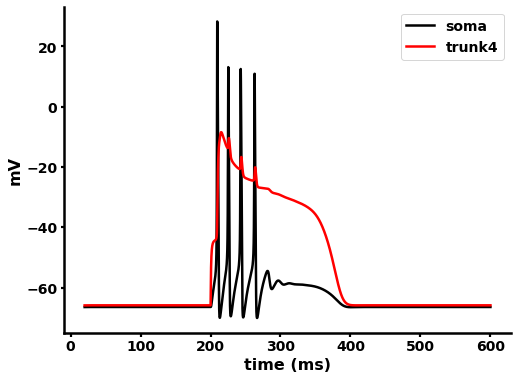

In [ ]:
vsoma_vec = h.Vector().record(soma(0.5)._ref_v)  # Membrane potential vector
vtrunk4_vec = h.Vector().record(trunk4(0.5)._ref_v)  # Membrane potential vector
t_vec = h.Vector().record(h._ref_t)  # Time stamp vector
# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)
# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vtrunk4_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))
plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, color='black', label='soma')
plt.plot(t_vec, vtrunk4_vec, color='red', label='trunk4')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.legend()
plt.show()

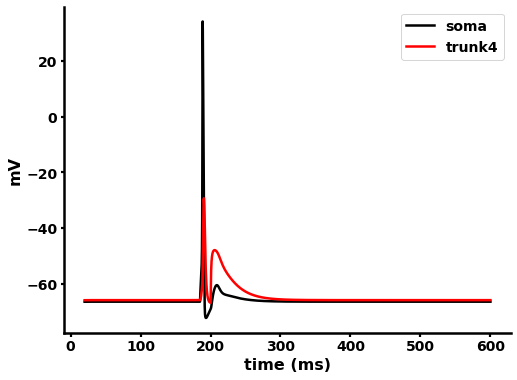

In [ ]:
# Stimuli combinations
ic.amp =0.2  # nA
nc.weight[0] =0.004
ic.delay = 185  # ms
# Run the simulation
h.finitialize(vinit)
h.continuerun(tstop)

# Remove the first 20ms to avoid artifacts
tremove = 20
vsoma_vec.remove(0, int(tremove/h.dt))
vtrunk4_vec.remove(0, int(tremove/h.dt))
t_vec.remove(0, int(tremove/h.dt))

plt.figure(figsize=(8, 6))
plt.plot(t_vec, vsoma_vec, color='black', label='soma')
plt.plot(t_vec, vtrunk4_vec, color='red', label='trunk4')
plt.xlabel('time (ms)')
plt.ylabel('mV')
plt.legend()
plt.show()